
# Bagging y Random Forest para Regresión

**Objetivo:** predecir el costo médico anual (`charges`) con variables demográficas y de estilo de vida (edad, sexo, IMC, hijos, tabaquismo, región). Comprender cómo árboles y ensambles capturan **no linealidades** e **interacciones**.

https://www.kaggle.com/datasets/mian91218/insurance


## Cargar y explorar los datos
Usamos el dataset `insurance` de **Seaborn**.


In [1]:
import seaborn as sns, pandas as pd, numpy as np
df = pd.read_csv("insurance.csv")
df.head()


,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520



**Variables**: `age`, `sex`, `bmi`, `children`, `smoker`, `region`, `charges`.



## Exploración visual rápida


<Axes: xlabel='smoker', ylabel='charges'>

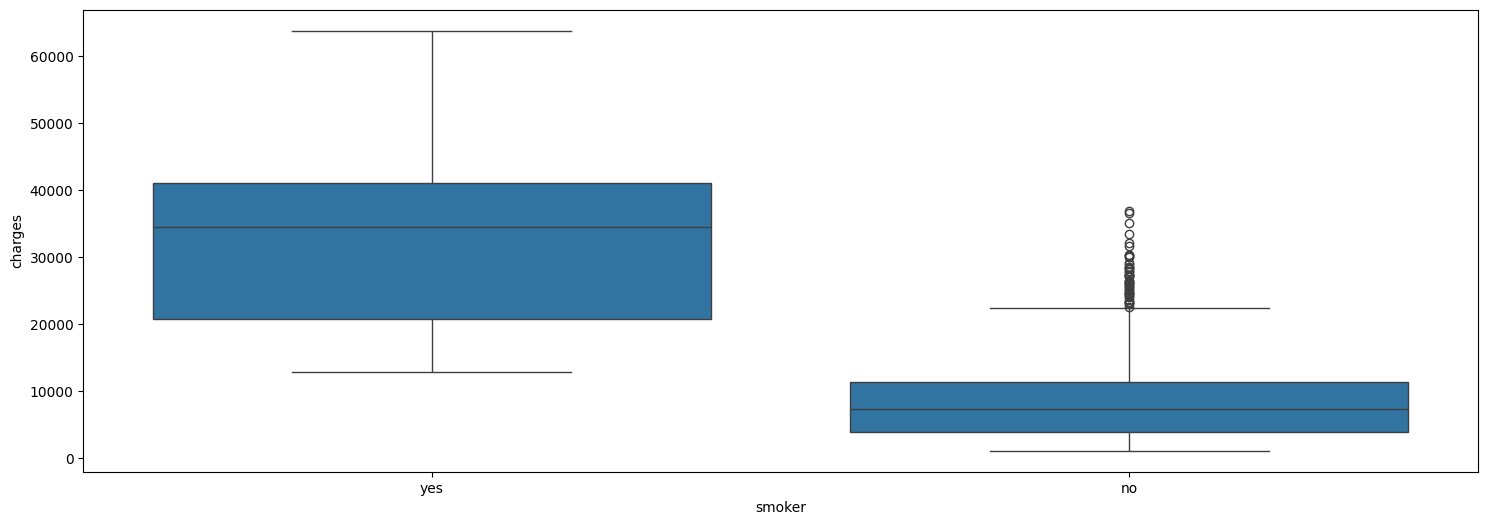

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
sns.boxplot(data=df, x="smoker", y="charges")



<Axes: xlabel='age', ylabel='charges'>

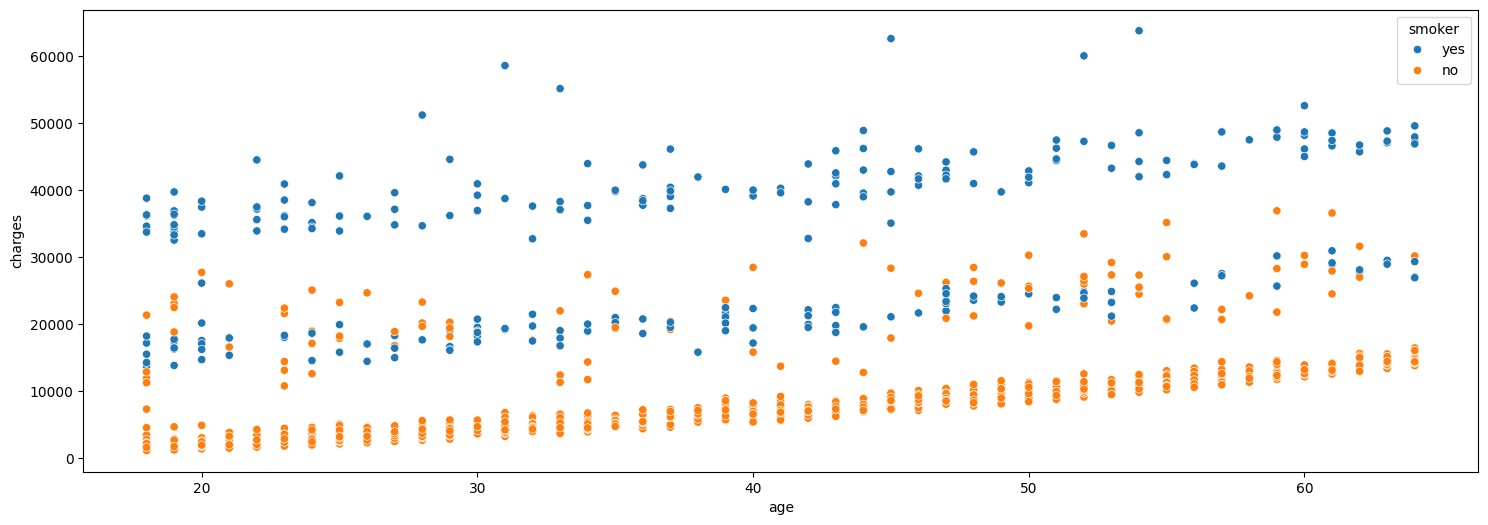

In [4]:
plt.figure(figsize=(18,6))
sns.scatterplot(data=df, x="age", y="charges", hue="smoker")



- Fumar incrementa notablemente los costos.  
- El costo crece con la edad, de forma no lineal.



## Preparación de datos
One-hot encoding para categóricas y split de entrenamiento/prueba.


In [5]:
from sklearn.model_selection import train_test_split

X= pd.get_dummies(df.drop(columns="charges"), drop_first=True)
y = df["charges"]



In [8]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.25, random_state=42)



## Árbol de regresión individual


In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

mae_tree = mean_absolute_error (y_test, y_pred_tree)
rmse_tree = mean_squared_error (y_test, y_pred_tree)
r2_tree = r2_score (y_test, y_pred_tree)

print(mae_tree)
print(rmse_tree)
print(r2_tree)


3211.7168189522386
44133472.411072835
0.7075144869507686



El árbol capta reglas complejas, pero es **inestable** (alta varianza).



## Bagging Regressor


In [18]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, bootstrap=True, random_state=42, n_jobs=-1 )

bag.fit(X_train, y_train)



BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, n_jobs=-1,
                 random_state=42)

In [21]:
y_pred_bag = bag.predict(X_test)
mae_bag = mean_absolute_error(y_test, y_pred_bag)
rmse_bag = mean_squared_error(y_test, y_pred_bag)
r2_bag = r2_score(y_test, y_pred_bag)

print(mae_bag)
print(rmse_bag)
print(r2_bag)


2783.752715531044
23595376.606490735
0.8436264935589393



El promedio de muchos árboles reduce la **varianza** y mejora la **estabilidad**.



## Random Forest Regressor


In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_features="sqrt", oob_score=True, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(mae_rf)
print(rmse_rf)
print(r2_rf)

2855.6190077762676
21775467.16098038
0.8556875691732769



## Comparación de resultados


/tmp/ipython-input-255137989.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="R²", data=results, palette="crest")


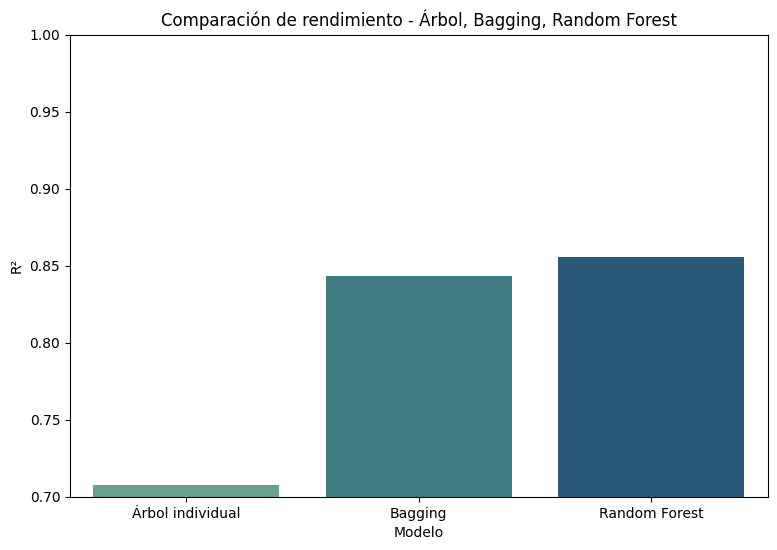

,Modelo,MAE,RMSE,R²
0,Árbol individual,3211.716819,4.413347e+07,0.707514
1,Bagging,2783.752716,2.359538e+07,0.843626
2,Random Forest,2855.619008,2.177547e+07,0.855688


In [24]:

import seaborn as sns, matplotlib.pyplot as plt, pandas as pd

results = pd.DataFrame({
    "Modelo": ["Árbol individual", "Bagging", "Random Forest"],
    "MAE": [mae_tree, mae_bag, mae_rf],
    "RMSE": [rmse_tree, rmse_bag, rmse_rf],
    "R²": [r2_tree, r2_bag, r2_rf]
})

plt.figure(figsize=(9,6))
sns.barplot(x="Modelo", y="R²", data=results, palette="crest")
plt.title("Comparación de rendimiento - Árbol, Bagging, Random Forest")
plt.ylim(0.7, 1)
plt.show()

results



**Esperado (aprox.)**: MAE ↓ y R² ↑ al pasar de Árbol → Bagging → Random Forest.



## Importancia de variables (Random Forest)


/tmp/ipython-input-405782508.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette="crest")


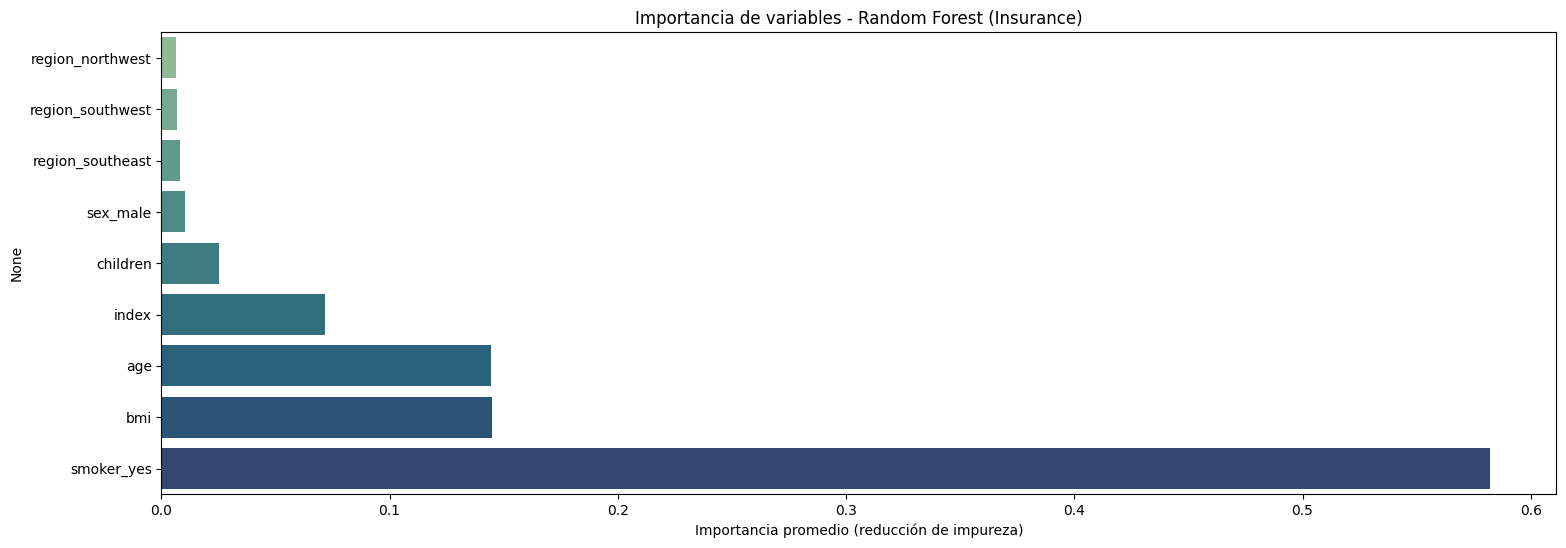

In [25]:

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(18,6))
sns.barplot(x=importances, y=importances.index, palette="crest")
plt.title("Importancia de variables - Random Forest (Insurance)")
plt.xlabel("Importancia promedio (reducción de impureza)")
plt.show()




## Visualización de desempeño


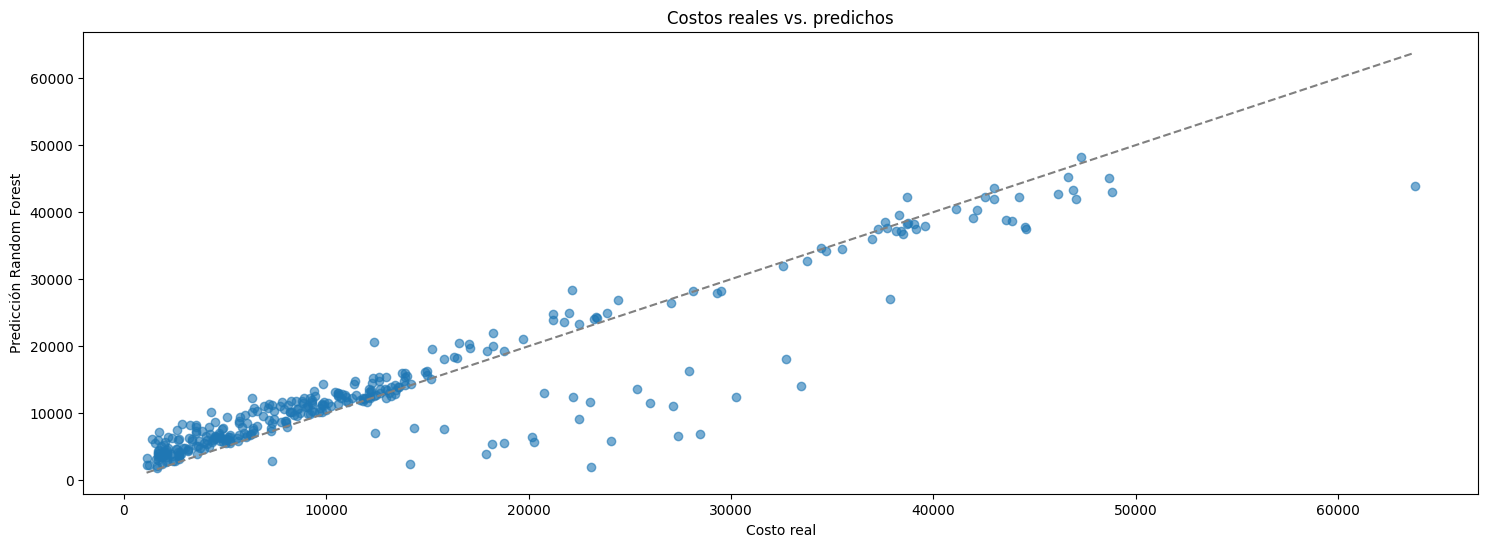

In [26]:

plt.figure(figsize=(18,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
lims = [min(y_test.min(), y_pred_rf.min()), max(y_test.max(), y_pred_rf.max())]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Costo real")
plt.ylabel("Predicción Random Forest")
plt.title("Costos reales vs. predichos")
plt.show()



Cuanto más cerca de la **diagonal**, mejor el ajuste. Los mayores errores suelen ser **casos extremos** (p. ej., fumadores con costos muy altos).



## Conclusiones y cierre

- Árbol: capta **no linealidades**, pero **sobreajusta**.  
- Bagging: promedia árboles → **reduce varianza**.  
- Random Forest: añade **diversidad** con *subconjuntos de variables* → **mejor generalización**.  

En práctica actuarial, estos modelos ofrecen estimaciones robustas del **costo esperado** sin imponer relaciones lineales rígidas y conservan interpretabilidad suficiente para **stakeholders** y **reguladores**.



> **Opcional:** instala dependencias si el entorno es nuevo (descomenta y ejecuta):
